In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
%pip install git+https://github.com/fkunstner/dataset-downloader.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/fkunstner/dataset-downloader.git to c:\users\root\appdata\local\temp\pip-req-build-lk5pkf6r
  Resolved https://github.com/fkunstner/dataset-downloader.git to commit 44e1689ee298d6fa62b7cf6097b39656447e244a
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
     ------------ --------------------------- 30.7/96.5 kB ? eta -:--:--
     ------------ --------------------------- 30.7/96.5 kB ? eta -:--:--
     ---------------------------- --------- 71.7/96.5 kB 787.7 kB/s eta 0:00:01
     -------------------------------------- 96.5/96.5 kB 690.3 kB/s eta 0:00:00
  Created wheel for dsdl: filename=dsdl-0.1.2-py3-none-any.whl size=7860 sha256=54da398f1280b63582363ed7f746b658603ecc04f84ebc3a1fd9f1f458b802d7
  Stored in directory: C:\Users\root\AppData\Local\Temp\pip-ephem-w

  Running command git clone --filter=blob:none --quiet https://github.com/fkunstner/dataset-downloader.git 'C:\Users\root\AppData\Local\Temp\pip-req-build-lk5pkf6r'


In [147]:
import dsdl

ds = dsdl.load("w1a")

X_train, y_train = ds.get_train()
print(X_train.shape, y_train.shape)

X_train = X_train.toarray()

X_test, y_test = ds.get_test()
print(X_test.shape, y_test.shape)

X_test = X_test.toarray()

(2477, 300) (2477,)
(47272, 300) (47272,)


In [148]:
print(np.max(X_train))
print(np.min(X_train))
print(np.unique(X_train))
print(np.unique(y_train))
print(np.sum(X_train))
print(np.sum(y_train))
print(np.sum(X_test))
print(np.sum(y_test))

1.0
0.0
[0. 1.]
[-1.  1.]
28410.0
-2333.0
551176.0
-44458.0


## Deterministic GD
Dataset: w1a

We investigate the dependence of the convergence rate on the clipping parameter c.

In [248]:
def sigmoid(z):
  return .5 * (1 + np.tanh(.5 * z))

def logloss(y_true, y_pred):
  epsilon = 1e-15
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
  log_loss = -np.mean(y_true * np.log((y_pred + 1) / 2) + (1 - y_true) * np.log((1 - y_pred + 1) / 2))
  return log_loss


def gradient_dw(x, y, w):
  '''In this function, we will compute the gardient w.r.to w ''' 
  dw = np.matmul((sigmoid(np.matmul(x,w)) - y).T, x) / y.shape[0]
  return dw

In [307]:
np.random.seed(seed = 42)

w = np.random.rand(300)

print(w.max())
z = sigmoid(np.matmul(X_train, w))
print(gradient_dw(X_train, y_train, w).max())
logloss(y_train, z)

0.9900538501042633
0.661179006056629


1.1131245873511948

In [308]:
def clipping(c, u):
    return min(1, c / (np.linalg.norm(u))) * u

In [300]:
from sklearn.metrics import log_loss

def DGD(X, y, w_0, c, eps = 0.01, lr = 10, iterations = 200):
    """
    Perform Deterministic GD
    X - features         (dataset_size, feature_num) [0, 1]
    y - labels           (dataset_size, )            either -1 or 1
    w_0 - init weights   (feature_num, )              
    c - clipping parameters(array)
    eps - target grad norm
    lr - learning rate

    returns 
    w - final weights;
    norms - norms of the gradients
    """
    w = []
    w_k = w_0.copy()
    
    loss = 1000
    losses = np.zeros((len(c), iterations))
    for ind in range(len(c)):
        w_k = w_0.copy()
        loss = 1000
        for iter in range(iterations):

            grad = gradient_dw(X, y, w_k)   
            if(c[ind]):
                grad = clipping(c[ind], grad)

            w_k = w_k - (lr * grad)
            loss = min(loss, log_loss(y, sigmoid(np.matmul(X, w_k))))
            losses[ind][iter] = loss
        # if(c[ind]):
        #     print("norms_unique for ind =", ind, np.unique(norms[ind]))
        w.append(w_k)
        print("c =", c[ind], "loss =", loss)
    
    return losses, w

In [309]:
w_0 = np.random.rand(X_test.shape[1])
c = [0, 0.1, 0.01, 0.001]
lr = 10
iterations = 200
eps = 0.01

losses, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)

print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

c = 0 loss = 0.3603847785630719
c = 0.1 loss = 0.26921224546786465
c = 0.01 loss = 0.2683798896482519
c = 0.001 loss = 3.571850778682325
MIN|MAX W's
-675.6494564087369 3.318914429022906
-59.24400398499442 1.1346709248205815
-5.5258050141776005 0.9886224341787244
-0.35665182267952283 0.9913669154744094


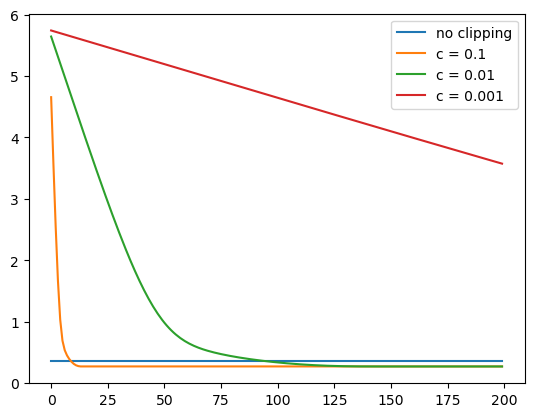

In [313]:
# plt.figure(figsize = (9, 3))

plt.plot(losses[0], label = "no clipping")
plt.plot(losses[1], label = "c = 0.1")
plt.plot(losses[2], label = "c = 0.01")
plt.plot(losses[3], label = "c = 0.001")

plt.legend()

In [314]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
c = [0, 0.1, 0.01, 0.001, 0.0001]
lr = 10
iterations = 5000
eps = 0.01

losses, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)

print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

c = 0 loss = 0.3650898354344644
c = 0.1 loss = 0.2233034899109592
c = 0.01 loss = 0.22292969136820376
c = 0.001 loss = 0.2228984931859726
c = 0.0001 loss = 0.2228962148965047
MIN|MAX W's
-16815.167894145485 81.44122562849986
-1492.448049557834 7.232207644013852
-149.23115673942328 0.7261458527788007
-14.910947597437982 0.07554512843388661
-1.4914552009326625 0.012301261353821029


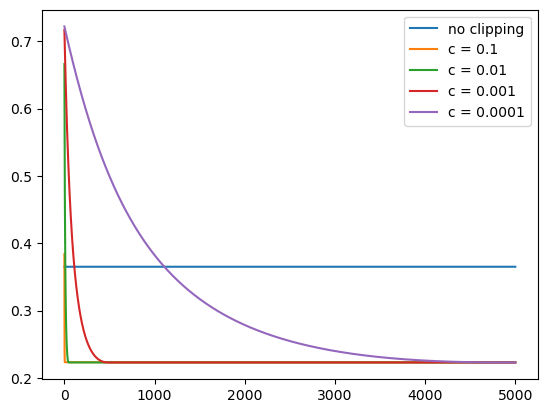

In [315]:
# plt.figure(figsize = (9, 3))

plt.plot(losses[0], label = "no clipping")
plt.plot(losses[1], label = "c = 0.1")
plt.plot(losses[2], label = "c = 0.01")
plt.plot(losses[3], label = "c = 0.001")
plt.plot(losses[4], label = "c = 0.0001")

plt.legend()

In [316]:
w_0 = np.random.rand(X_test.shape[1]) * 0.01
iterations = 50
eps = 0.01

lr = 0.5
c = [0]
losses0, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 133
c = [0.1]
losses1, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 233
c = [0.01]
losses2, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

lr = 1000
c = [0.001]
losses3, w = DGD(X_test, y_test, w_0, c, eps, lr, iterations)
print("MIN|MAX W's")
for i in w:
    print(min(i), max(i))

c = 0 loss = 0.22335815609534868
MIN|MAX W's
-8.585919379594545 0.03906943665323406
c = 0.1 loss = 0.31148007155707247
MIN|MAX W's
-198.4891990755299 0.9482142337107246
c = 0.01 loss = 0.22440455378290686
MIN|MAX W's
-34.75943496184799 0.16436997325157796
c = 0.001 loss = 0.223318481112449
MIN|MAX W's
-14.915601467228548 0.06901613828567854


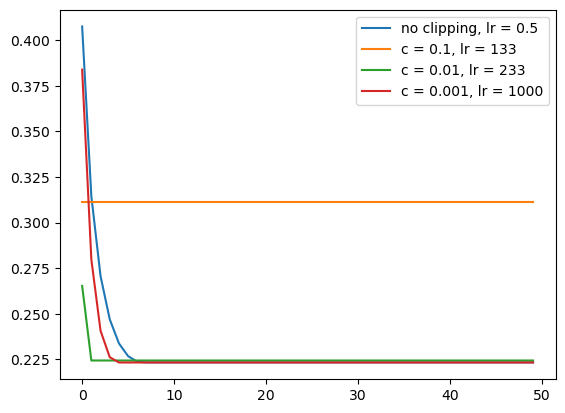

In [318]:
plt.plot(losses0[0], label = "no clipping, lr = 0.5")
plt.plot(losses1[0], label = "c = 0.1, lr = 133")
plt.plot(losses2[0], label = "c = 0.01, lr = 233")
plt.plot(losses3[0], label = "c = 0.001, lr = 1000")

plt.legend()

In [ ]:
from sklearn.metrics import log_loss

def SGD(X, y, w_0, c, eps = 0.01, lr = 10, iterations = 200):
    """
    Perform Deterministic GD
    X - features         (dataset_size, feature_num) [0, 1]
    y - labels           (dataset_size, )            either -1 or 1
    w_0 - init weights   (feature_num, )              
    c - clipping parameters(array)
    eps - target grad norm
    lr - learning rate(array)

    returns 
    w - final weights;
    norms - norms of the gradients
    """
    w = []
    w_k = w_0.copy()
    
    loss = 1000
    losses = np.zeros((len(c), iterations))
    for ind_c in range(len(c)):
        w_k = w_0.copy()
        loss = 1000
        for ind_lr in lr:
            for iter in range(iterations):

                grad = gradient_dw(X, y, w_k)   
                if(c[ind_c]):
                    grad = clipping(c[ind_c], grad)

                w_k = w_k - (lr * grad)
                loss = min(loss, log_loss(y, sigmoid(np.matmul(X, w_k))))
                losses[ind_c][iter] = loss
            # if(c[ind]):
            #     print("norms_unique for ind =", ind, np.unique(norms[ind]))
            w.append(w_k)
            print("c =", c[ind_c], "loss =", loss)
    
    return losses, w